# Support Vector Machines

https://jgreitemann.github.io/svm-demo

Support vector machines ou máquina de vetores de suporte (SVMs) é uma classe de algoritmos particularmente poderosa. Nesta aula vamos entender como funciona este algoritmo em como usá-lo em problemas de classificação.


Vamos começar importando as bibliotecas:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

Na aula passada vimos que o classificador KNN calcula a distância de um novo dado para todos os dados presentes na base de trainamento para verificar quais são os vizinhos mais próximos e então atribuir uma classe para este dado. 

Nesta aula iremos aprender sobre o SVM, que é um classificador discriminativo linear, ou seja, ele vai calcular uma fronteira entre as classes presentes no dados. 

Vamos partir para um exemplo. Considere um simples case de uma tarefa de classificação onde as duas classes são bem separadas. 

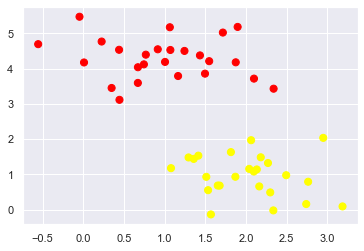

In [4]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

Como dito, o SVM vai tentar desenhar uma fronteira que separa os dois conjuntos dados e assim criando um modelo de classificação. 

Para um exemplo bi-dimensional como mostrado acima, nós podemos tentar traçar esta linha manualemnte. Mas imediatamente vemos um problem: Existe mais de uma possibilidade de traçar uma fronteira que possa discriminar perfeitamente as duas clases! 

Podemos fazer da seguinte maneira:

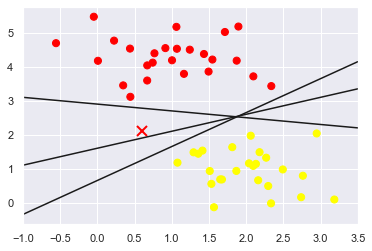

In [12]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

Podemos observar que estas são fronteiras muito diferentes, que entretanto, perfeitamente discriminam as duas classes. Dependendo da fronteira que vc escolher, o novo dado (o "X" vermelho) pode ser atribuido a classe amarela ou vermelha. 

Evidentemente, vemos que apenas desenhar linhas entre as classes não é o suficiente. Logo precisamos de uma técnica mais sofisticada. 

## Support Vector Machines: Maximizando as margens.

Support vector machines oferecem uma nova maneira de melhores isto.
A ideia central é ao invés de simplesmente desnhar fronteiras, podemos definir margens entorno de cada linha cuja largura vai até o ponto mais próximo daquela linha. 

Vejamos:


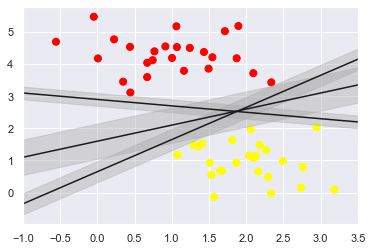

In [18]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

Para o SVM a fronteira que maximizar esta margem é a fronteira ótima de separação dos dados. 


### Treinando um SVM

Vamos ver o resultado de real de como o SVM encontra estas fronteiras. 

Neste momento, nós vamos usar um kernel linear e configurar o parâmetro ``C`` alto. Ele controla o trade-off entre o limite de decisão suave e a classificação correta dos pontos de treinamento. Um grande valor de c significa que você receberá mais pontos de treinamento corretamente.

In [34]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

Função para plotar a fronteira de decisão

In [35]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

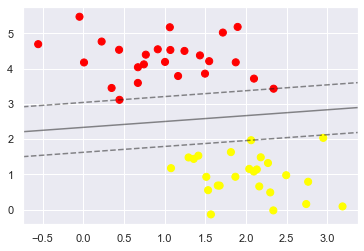

In [36]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

Esta é a linha divisória que maximiza a margem entre os dois conjuntos de pontos. Observe que alguns dos pontos de treinamento apenas tocam a margem: eles são indicados pelos círculos negros nesta figura. Estes pontos são os elementos centrais deste ajuste, e são conhecidos como os vetores de suporte, e dão ao algoritmo seu nome. No Scikit-Learn, a identidade destes pontos é armazenada no atributo support_vectors_ do classificador:


In [38]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

Uma chave para o sucesso deste classificador é que para o ajuste, somente a posição dos vetores de suporte importa; quaisquer pontos mais distantes da margem que estejam do lado correto não modificam o ajuste! Tecnicamente, isto é porque estes pontos não contribuem para a função de perda usada para se ajustar ao modelo, portanto, sua posição e número não importam, desde que não cruzem a margem.

Podemos ver isto, por exemplo, se traçarmos o modelo aprendido dos primeiros 60 pontos e dos primeiros 120 pontos deste conjunto de dados:



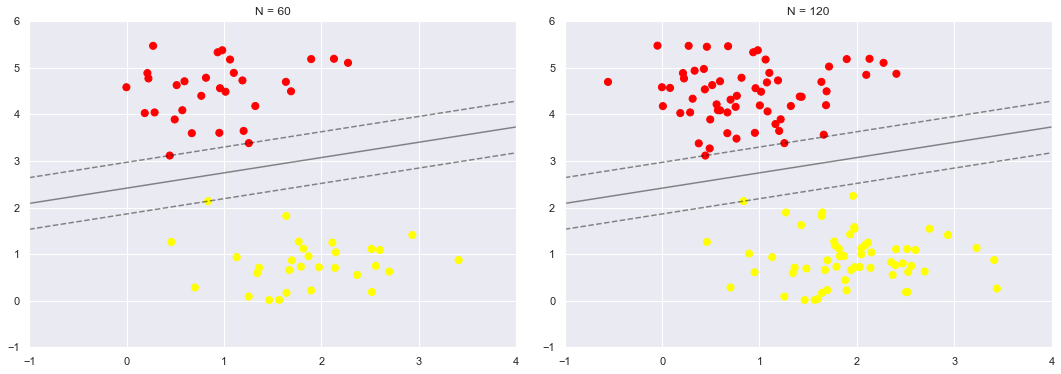

In [39]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

No painel da esquerda, vemos o modelo e os vetores de apoio para 60 pontos de treinamento. No painel direito, duplicamos o número de pontos de treinamento, mas o modelo não mudou: os três vetores de suporte do painel esquerdo ainda são os vetores de suporte do painel direito. Esta insensibilidade ao comportamento exato dos pontos distantes é um dos pontos fortes do modelo SVM.

Se você estiver rodando este notebook ao vivo, você pode usar os widgets interativos do IPython para visualizar esta característica do modelo SVM de forma interativa:

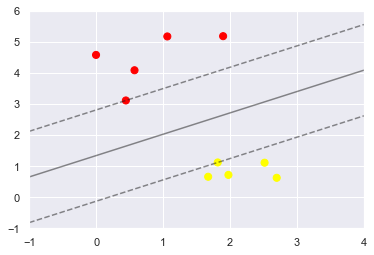

In [42]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 200], ax=fixed(None));

### Além das fronteiras lineares: Kernel SVM

Onde a SVM se torna extremamente poderosa é quando é combinada com os kernels.
Kernels são um conjunto de funções matemáticas que tomam os dados como entrada e transforma-os na forma requerida. Diferentes algoritmos SVM utilizam diferentes tipos de funções do kernel. Estas funções podem ser de diferentes tipos. Por exemplo, função de base linear, não linear, polinomial, radial (RBF), e sigmóide.

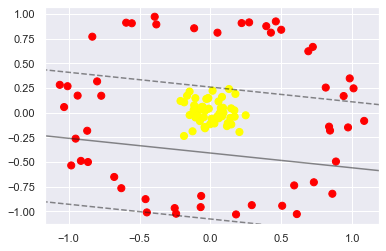

In [44]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

É evidente que nenhuma discriminação linear será capaz de separar estes dados. Mas podemos projetar os dados em uma dimensão mais elevada, de modo que um separador linear seja suficiente. Por exemplo, uma projeção simples que poderíamos usar seria calcular uma função de base radial:

In [48]:
r = np.exp(-(X ** 2).sum(1))

Podemos visualizar esta dimensão de dados extra usando um gráfico tridimensional 

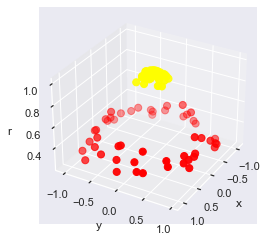

In [49]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(X[:, 0], X[:, 1], r,  c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')
plot_3D()

Podemos ver que com esta dimensão adicional, os dados se tornam trivialmente separáveis linearmente, desenhando um plano de separação em, digamos, r=0,7.

Aqui tivemos que escolher e ajustar cuidadosamente nossa projeção: se não tivéssemos centrado nossa função de base radial no local correto, não teríamos visto resultados tão limpos e linearmente separáveis. Em geral, a necessidade de fazer tal escolha é um problema: gostaríamos de, de alguma forma, encontrar automaticamente as melhores funções de base a serem utilizadas.

Uma estratégia para este fim é calcular uma função base centrada em cada ponto do conjunto de dados, e deixar que o algoritmo SVM peneirar os resultados. Este tipo de transformação da função base é conhecida como transformação do kernel, pois se baseia em uma relação de similaridade (ou kernel) entre cada par de pontos.

Um problema potencial com esta estratégia - projetando 𝑁 pontos em dimensões 𝑁 - é que ela pode se tornar muito computacionalmente intensiva à medida que 𝑁 se torna grande. Entretanto, devido a um pequeno procedimento conhecido como o  [*kernel trick*](https://en.wikipedia.org/wiki/Kernel_trick), um ajuste nos dados transformados em kernel pode ser feito implicitamente - isto é, sem nunca construir a representação completa 𝑁 -dimensional da projeção do kernel! Este truque do kernel está embutido na SVM, e é uma das razões pelas quais o método é tão poderoso.

No Scikit-Learn, podemos aplicar SVM kernelizado simplesmente mudando nosso kernel linear para um kernel RBF (função de base radial), usando o modelo de kernel hyperparameter:

In [50]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0)

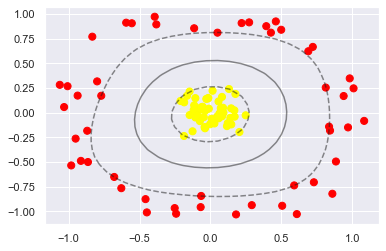

In [52]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

Usando esta máquina vetorial de suporte kernelizado, aprendemos um limite de decisão não linear adequado. Esta estratégia de transformação do núcleo é usada freqüentemente no aprendizado da máquina para transformar métodos lineares rápidos em métodos não lineares rápidos, especialmente para modelos nos quais o kernel trick pode ser usado.

### Melhorando o SVM: Suavizando as Margens

ossa discussão até agora tem se centrado em torno de conjuntos de dados muito limpos, nos quais existe um limite de decisão perfeito.
Mas e se seus dados tiverem alguma quantidade de sobreposição?
Por exemplo, você pode ter dados como este:

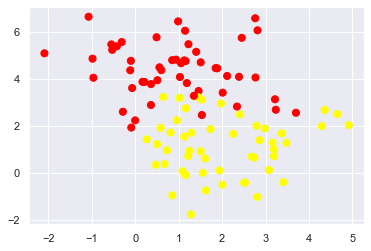

In [53]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

Para lidar com este caso, a implementação da SVM tem um parametro que "suaviza" a margem: isto é, permite que alguns dos pontos penetrem na margem se isso permitir um melhor ajuste. A rigidez da margem é controlada por um parâmetro de afinação, mais freqüentemente conhecido como 𝐶 . Para um 𝐶 muito grande, a margem é dura, e os pontos não podem estar nela. Para o menor 𝐶 , a margem é mais suave, e pode ser aumentada para abranger alguns pontos.

A figura mostrada abaixo dá uma idéia visual de como um parâmetro 𝐶 variável afeta o ajuste final, através do amolecimento da margem:

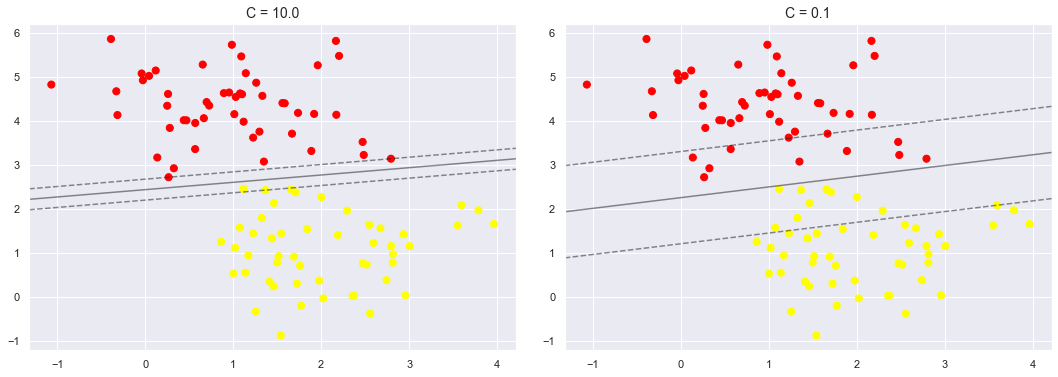

In [54]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

O valor ótimo do parâmetro 𝐶 dependerá de seu conjunto de dados, e deve ser ajustado usando a validação cruzada ou um procedimento similar

## Examplo: Reconhecimento Facial

Como exemplo do SVM em ação, vamos dar uma olhada no problema de reconhecimento facial.
Vamos utilizar o conjunto de dados Labeled Faces in the Wild, que consiste em vários milhares de fotos coletadas de várias figuras públicas.
Um buscador para o conjunto de dados está incorporado no Scikit-Learn:

In [65]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Vamos traçar alguns desses rostos para ver com o que estamos trabalhando:


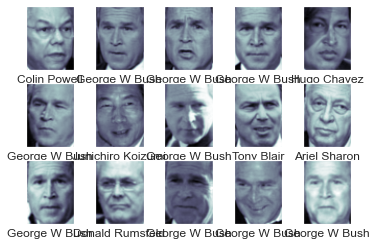

In [70]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Cada imagem contém [62×47] ou quase 3.000 pixels. Poderíamos prosseguir simplesmente usando cada valor de pixel como uma característica, mas muitas vezes é mais eficaz usar algum tipo de pré-processador para extrair características mais significativas; aqui usaremos uma análise de componentes principais para extrair 150 componentes fundamentais para alimentar nosso classificador SMV. Podemos fazer isso de forma mais direta, agrupando o pré-processador e o classificador em uma única pipeline:

In [71]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

Para testar nossa saída de classificadores, vamos dividir os dados em um conjunto de treinamento e testes:

In [72]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

Finalmente, podemos usar uma validação cruzada de busca em grade para explorar combinações de parâmetros. Aqui ajustaremos C (que controla a suavidade da margem) e gama (que controla o tamanho do núcleo da função de kernel), e determinaremos o melhor modelo:

In [73]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 1min 36s, sys: 25 s, total: 2min 1s
Wall time: 21 s
{'svc__C': 10, 'svc__gamma': 0.001}


Agora com este modelo validado, podemos prever as classes para os dados de teste, o que o modelo ainda não viu:

In [74]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

Vamos dar uma olhada em algumas das imagens de teste juntamente com seus valores previstos:

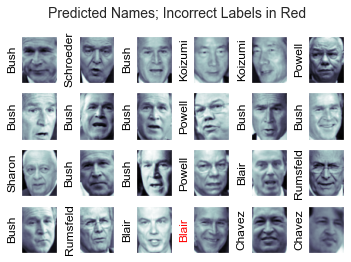

In [75]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

Desta pequena amostra, nosso estimador ideal rotulava erroneamente apenas uma única face (a face de Bush na fila inferior era rotulada erroneamente como Blair). Podemos ter uma melhor noção do desempenho de nosso estimador usando o relatório de classificação, que lista as estatísticas de recuperação etiqueta por etiqueta:

In [76]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.73      0.69        15
     Colin Powell       0.80      0.87      0.83        68
  Donald Rumsfeld       0.74      0.84      0.79        31
    George W Bush       0.92      0.83      0.88       126
Gerhard Schroeder       0.86      0.83      0.84        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.92      1.00      0.96        12
       Tony Blair       0.85      0.95      0.90        42

         accuracy                           0.85       337
        macro avg       0.83      0.84      0.84       337
     weighted avg       0.86      0.85      0.85       337



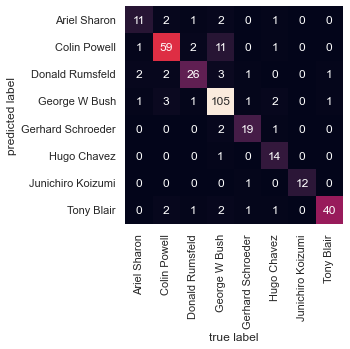

In [77]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Isto nos ajuda a ter uma noção de quais classes podem ser confundidas pelo modelo.

Para uma tarefa de reconhecimento facial no mundo real, na qual as fotos não vêm pré-cortadas em grades agradáveis, a única diferença no esquema de classificação facial é a seleção de características: seria necessário usar um algoritmo mais sofisticado para encontrar as faces e extrair características que são independentes da pixelação. Para este tipo de aplicação, uma boa opção é fazer uso do OpenCV, que, entre outras coisas, inclui implementações pré-treinadas de ferramentas de extração de recursos de última geração para imagens em geral e rostos em particular.

## Resumo
Vimos aqui uma breve introdução intuitiva aos princípios por trás das máquinas vetoriais de suporte. Estes métodos são um poderoso método de classificação por uma série de razões:

- Sua dependência de relativamente poucos vetores de suporte significa que eles são modelos muito compactos, e ocupam muito pouca memória.
- Uma vez que o modelo é treinado, a fase de previsão é muito rápida.
- Por serem afetados apenas por pontos próximos à margem, eles trabalham bem com dados de alta dimensão - mesmo dados com mais dimensões do que amostras, o que é um regime desafiador para outros algoritmos.
- Sua integração com os métodos de kernel os torna muito versáteis, capazes de se adaptar a muitos tipos de dados.


Entretanto, as SVMs também têm algumas desvantagens:

- O dimensionamento com o número de amostras 𝑁 é [𝑁3] na pior das hipóteses, ou [𝑁2] para implementações eficientes. Para um grande número de amostras de treinamento, este custo computacional pode ser proibitivo.
- Os resultados dependem fortemente de uma escolha adequada para o parâmetro de suavizacao 𝐶 . Isto deve ser cuidadosamente escolhido através de validação cruzada, que pode ser cara à medida que os conjuntos de dados crescem em tamanho.

